In [1]:
%load_ext autoreload
%autoreload 2
import torch 
import glob
from torchvision.io import read_image
from matplotlib import pyplot as plt
from math import pi as PI


In [2]:
images = glob.glob("renders/*.png")
images = sorted(images,key=lambda fn:int(fn.split(".")[0].split("_")[1]))

all_images = torch.stack([read_image(p) for p in images]).cuda().float()
all_images /= 255.0


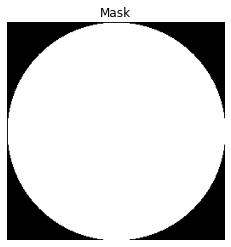

In [3]:
img_size = all_images.shape[2:4]
x = torch.arange(-1,1,2/img_size[0])
y = torch.arange(-1,1,2/img_size[1])
x_grid,y_grid = torch.meshgrid(x,y,indexing="ij")
mask = (x_grid.square()+y_grid.square())<1
plt.imshow(mask,cmap="gray")
plt.axis("off")
plt.title("Mask")
mask = mask.float().cuda()

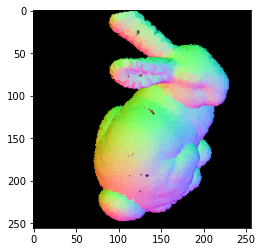

In [4]:

alpha_mask = all_images[:,3:4] * mask
alpha_weighted = all_images[:,:3] * alpha_mask
avg_colors = alpha_weighted.sum(dim=(2,3)) / alpha_mask.sum(dim=(2,3))

plt.imshow((all_images[4,:3]*mask).permute(1,2,0).cpu())

12 14


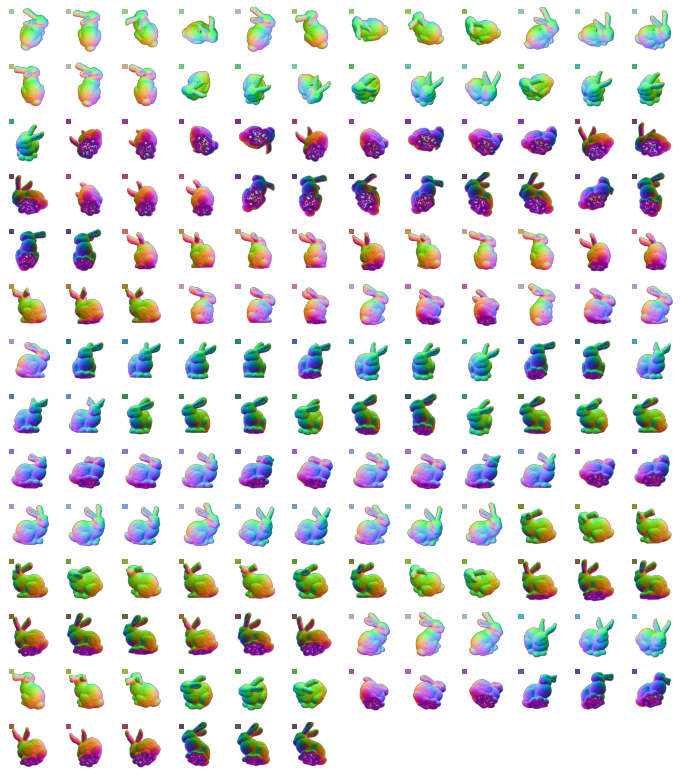

In [5]:
import math
from matplotlib.patches import Rectangle

num_images = avg_colors.shape[0]

num_cols = int(math.sqrt(num_images))
num_rows = math.ceil(num_images/num_cols)

print(num_cols,num_rows)

fig, axes = plt.subplots(num_rows,num_cols,figsize=(num_cols,num_rows))

for i in range(num_rows*num_cols):
    row = i//num_cols
    col = i%num_cols
    ax = axes[row][col]
    ax.set_axis_off()
    if i >= num_images:
        continue
    
    ax.imshow(all_images[i].cpu().permute((1,2,0)))
    ax.add_patch(Rectangle((10,10),30,30,facecolor=avg_colors[i].cpu().numpy()))

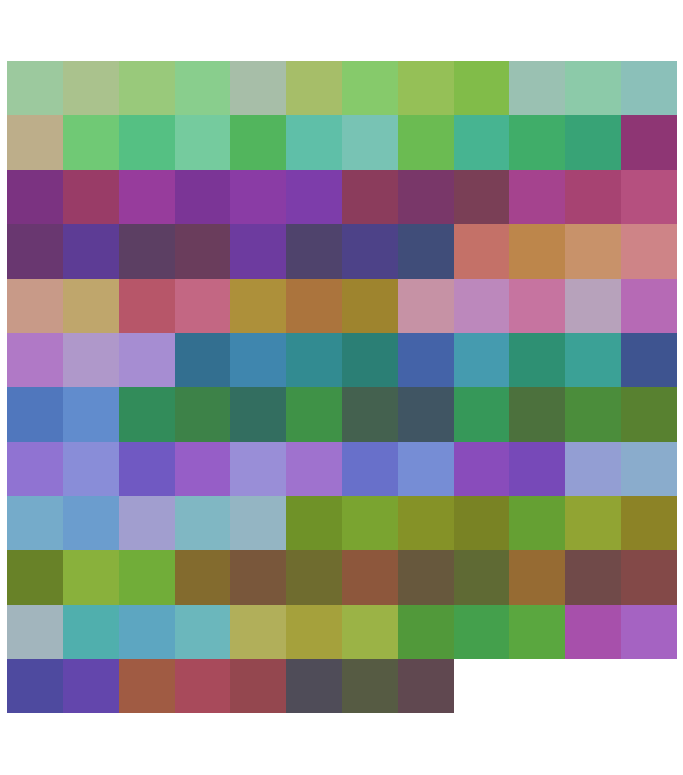

In [6]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(num_cols,num_rows))

ax.set_ylim((0,num_rows*10))
ax.set_xlim((0,num_cols*10))
ax.set_axis_off()
for i in range(num_images):
    row = num_cols- i//num_rows
    col = i%num_rows
    ax.add_patch(Rectangle((col*10,row*10),10,10,facecolor=avg_colors[i].cpu().numpy()))

In [7]:
from plyfile import PlyData, PlyElement
import numpy as np

plydata = PlyData.read('../sphere.ply')
positions = np.stack([plydata["vertex"].data["x"],plydata["vertex"].data["y"],plydata["vertex"].data["z"]]).T
cameras = torch.from_numpy(positions)

In [8]:
def to_spherical(coords):
    assert (coords.norm(p=2,dim=1)-1 < 1e-8).all(), "must be of length 1"

    theta = coords[:,2].acos()
    phi = torch.atan2(coords[:,1],coords[:,0]) + PI
    return torch.stack([theta,phi]).T


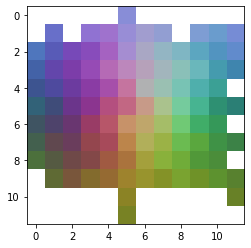

In [9]:

cameras_spherical = to_spherical(cameras)

res = 12

pos_norm = cameras_spherical.clone()
pos_norm[:,0]/=PI
pos_norm[:,1]/=2*PI

# scale to the center of the pixels and convert to index
pos_norm = (pos_norm * (res-1) + 1/ res).long()
# plt.imshow(render.cpu())
#render[pos_norm] = 0

#plt.imshow(render)
render = torch.ones((res,res,3))

for i,p in enumerate(pos_norm):
    render[p[0]][p[1]] = avg_colors[i].cpu()
plt.imshow(render)

torch.Size([315, 315])

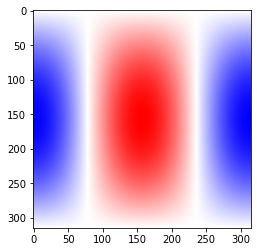

In [10]:

from sh import get_spherical_harmonics,get_spherical_harmonics_element
resolution = 100
x = torch.arange(0,PI,1/resolution)
y = torch.arange(0,2*PI,2/resolution)
x_grid,y_grid = torch.meshgrid(x,y, indexing='ij')
values = get_spherical_harmonics_element(1,1,x_grid,y_grid)


plt.imshow(values,cmap="bwr")
values.shape

In [238]:
l = 2

y_lm = get_spherical_harmonics(l,cameras_spherical[:,0],cameras_spherical[:,1])

num_coef = y_lm.shape[1]

delta = 2* PI**2 / cameras_spherical.shape[0]

fn = avg_colors.cpu()

theta_sin = cameras_spherical[:,:1].sin()

a_lm = ((y_lm*theta_sin*delta).T@fn)
a_lm

tensor([[ 0.0483,  0.0163,  0.0149],
        [ 0.0180,  0.0169,  0.0584],
        [-0.5928, -0.5878, -0.6292],
        [-0.0107, -0.0021,  0.0128],
        [-0.0303,  0.0067, -0.0327]])

In [244]:
y_lm.shape, a_lm.shape

(torch.Size([100, 100, 5]), torch.Size([5, 3]))

tensor(-1.1475) tensor(1.2829)


(-0.5, 99.5, 99.5, -0.5)

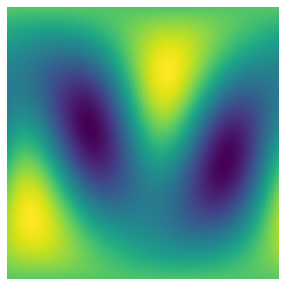

In [245]:
x = torch.arange(0,PI,PI/resolution)
y = torch.arange(0,2*PI,2*PI/resolution)
x_grid,y_grid = torch.meshgrid(x,y, indexing='ij')

y_lm = get_spherical_harmonics(l,x_grid,y_grid)

img_data = y_lm.sum(2)#(y_lm@a_lm)
print(img_data.min(),img_data.max())

plt.figure(figsize=(5,5))
plt.imshow(img_data+0.5)
plt.axis("off")

In [ ]:
data = [(*list(pos.numpy()),*list((color*255).byte().numpy())) for (pos,color) in zip(cameras,avg_colors.cpu())]
vertices = np.array(data,dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4'),('red', 'u1'),('green', 'u1'),('blue', 'u1')])

ply_file = PlyData(
        [
            PlyElement.describe(
                vertices, 'vertex',
            ),
            plydata["face"]
        ],
         text=True
    )

ply_file.write("vis.ply")

In [ ]:
plydata["face"]

In [ ]:
avg_colors